In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import pandas as pd
import tensorflow as tf
import math
import tensorflow_addons as tfa
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from random import sample
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam, SGD
from  tensorflow.keras.metrics import AUC, Precision, Recall, Accuracy
from tensorflow.keras.losses import BinaryCrossentropy, CategoricalCrossentropy

from utils import (
    plot_metrics,
    F1Score,
    plot_accuracy,
)


c:\Users\Paul\anaconda3\lib\site-packages\tensorflow_addons\utils\ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.7.0 and strictly below 2.10.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.10.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  warnings.warn(


In [2]:
# To Activate GPU if there is
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print("Num GPUs Available: ", len(physical_devices))
tf.config.experimental.set_memory_growth(physical_devices[0], True)

Num GPUs Available:  1


In [3]:
data_directory = 'dataset'

train_img = pd.read_csv(os.path.join(data_directory, 'MURA-v1.1_mod/train_image_paths.csv'), names=['path'])

train_img

,path
0,MURA-v1.1_mod/train/XR_SHOULDER/patient00001/s...
1,MURA-v1.1_mod/train/XR_SHOULDER/patient00001/s...
2,MURA-v1.1_mod/train/XR_SHOULDER/patient00001/s...
3,MURA-v1.1_mod/train/XR_SHOULDER/patient00002/s...
4,MURA-v1.1_mod/train/XR_SHOULDER/patient00002/s...
...,...
36803,MURA-v1.1_mod/train/XR_HAND/patient11183/study...
36804,MURA-v1.1_mod/train/XR_HAND/patient11183/study...
36805,MURA-v1.1_mod/train/XR_HAND/patient11184/study...
36806,MURA-v1.1_mod/train/XR_HAND/patient11184/study...


In [4]:
orig_len = len(train_img)

# Split the train into training and validation dataset
valid_img= train_img.sample(frac=0.2, random_state=1337)

# Remove the selected image paths for the validation in training img paths
train_img = train_img.drop(valid_img.index)

valid_length = len(valid_img)
train_length = len(train_img)

print('Original Size of Train: ', orig_len)
print('Validation dataset size: ', valid_length)
print('Train dataset size: ', train_length)

assert(orig_len == (valid_length + train_length))

Original Size of Train:  36808
Validation dataset size:  7362
Train dataset size:  29446


In [5]:
# Add labels to the paths
train_img['label'] = train_img['path'].map(lambda x: '1' if 'positive' in x else '0')
valid_img['label'] = valid_img['path'].map(lambda x: '1' if 'positive' in x else '0')

train_class_frequency = pd.DataFrame(train_img['label'].value_counts())
valid_class_frequency = pd.DataFrame(valid_img['label'].value_counts())

print('Train Data Class Distribution: \n',train_class_frequency)
print('Validation Data Class Distribution: \n',valid_class_frequency)


Train Data Class Distribution: 
    label
0  17483
1  11963
Validation Data Class Distribution: 
    label
0   4452
1   2910


In [6]:
img_height = img_width = 240

def resize_img(img):
    try:
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    except:
        print('error in resizing')
        img1 = isinstance(img, type(None))
        print('Does image is none: ', img1)
        print(img.shape)
    return cv2.resize(img, (img_height, img_width))

def canny_cropping(img):
    convert_img = np.array(img, dtype=np.uint8)

    gray = cv2.cvtColor(convert_img, cv2.COLOR_RGB2GRAY)


    ave_brightness = math.floor(np.average(gray))
    min_pixel = min(gray.flatten())

    edges = cv2.Canny(gray, min_pixel, ave_brightness)
    cnts = cv2.findContours(edges.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = cnts[0] if len(cnts) == 2 else cnts[1]
    cnts = sorted(cnts, key=cv2.contourArea, reverse=True)

    for c in cnts:
        x, y, w, h = cv2.boundingRect(edges)
        gray = gray[y:y+h, x:x+w]
        break

    return gray

def preprocessing_without_clahe(img):
    cropped = canny_cropping(img)
    return resize_img(cropped)


In [7]:
data_path = 'dataset/'
batch = 8
train_batches = ImageDataGenerator(
    rotation_range=30,
    horizontal_flip=True,
    preprocessing_function=preprocessing_without_clahe
).flow_from_dataframe(
    target_size=(img_height, img_width),
    dataframe=train_img, 
    directory= data_path,
    class_mode='binary',
    x_col='path',
    y_col='label',
    batch_size=batch)

valid_batches = ImageDataGenerator(
    preprocessing_function=preprocessing_without_clahe
).flow_from_dataframe(
    target_size=(img_height, img_width),
    dataframe= valid_img,
    directory= data_path,
    class_mode='binary',
    x_col='path',
    y_col='label',
    shuffle=False,
    batch_size=batch)


Found 29446 validated image filenames belonging to 2 classes.
Found 7362 validated image filenames belonging to 2 classes.


In [8]:
METRICS = [ 
    tf.keras.metrics.BinaryAccuracy(),
    tf.keras.metrics.Precision(name="precision"),
    tf.keras.metrics.Recall(name="recall"),
    tfa.metrics.CohenKappa(name="cohen_kappa", num_classes=2),
    F1Score(name="f1_score"),
]

reduce_lr_on_plateau = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_cohen_kappa",
    verbose=1,
    patience=4,
    mode="max",
    factor=0.1,
    min_lr=1e-5,
)

In [9]:
def build_model():

    # Create GlobalAveragePooling Layer
    global_ave_layer = tf.keras.layers.GlobalAveragePooling2D()

    prediction_layer = tf.keras.layers.Dense(1, activation='sigmoid')

    inputs = tf.keras.Input(shape=(img_height, img_width, 3))

    pretrained_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B1(
        input_tensor = inputs,
        include_top=False,
        weights='imagenet',
        classes=2,
    )
    
    pretrained_model.trainable = False

    x = global_ave_layer(pretrained_model.output)
    x = tf.keras.layers.Dense(512, activation='swish')(x)
    x = tf.keras.layers.BatchNormalization(momentum=0.9)(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    x = tf.keras.layers.Dense(256, activation='swish')(x)
    x = tf.keras.layers.BatchNormalization(momentum=0.9)(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    outputs = prediction_layer(x)
    model_without_clahe = Model(inputs, outputs)

    model_without_clahe.compile(
    optimizer=SGD(learning_rate=0.001, momentum=0.9), 
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=METRICS)

    return model_without_clahe


In [10]:
model_without_clahe = build_model()

In [11]:
with open('models/summary/feature_extraction_modified_no_CLAHE_summary.txt','w') as fh:
    model_without_clahe.summary(print_fn=lambda x: fh.write(x + '\n'))

In [12]:
print(np.sum([tf.keras.backend.count_params(w) for w in model_without_clahe.trainable_weights]))
print(np.sum([tf.keras.backend.count_params(w) for w in model_without_clahe.non_trainable_weights]))

788993
6932660


In [13]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_cohen_kappa",
    verbose=1,
    patience=5,
    mode="max",
    baseline=0.0,
    restore_best_weights=True,
)

base_model_name = 'efficientnetv2-b1'
model_path = f'models/without_clahe/{base_model_name}_modified_feature_extractor_v2.h5'
checkpoint_feature = tf.keras.callbacks.ModelCheckpoint(
    filepath=model_path,
    monitor='val_cohen_kappa',
    mode='max',
    save_best_only = True,
)

feature_training = f'training_records/without_clahe/{base_model_name}_modified_feature_extraction_v2.csv'
logs = tf.keras.callbacks.CSVLogger(filename=feature_training, separator=',')

In [14]:
if os.path.isfile(model_path) is False:
    history = model_without_clahe.fit(
        train_batches, 
        validation_data=valid_batches, 
        epochs=25, 
        verbose=2,
        callbacks=[early_stopping, checkpoint_feature, logs, reduce_lr_on_plateau],
    )

Epoch 1/25
3681/3681 - 724s - loss: 0.6604 - binary_accuracy: 0.6399 - precision: 0.5663 - recall: 0.4853 - cohen_kappa: 0.2363 - f1_score: 0.5227 - val_loss: 0.5559 - val_binary_accuracy: 0.7263 - val_precision: 0.6969 - val_recall: 0.5443 - val_cohen_kappa: 0.4049 - val_f1_score: 0.6112 - lr: 0.0010 - 724s/epoch - 197ms/step
Epoch 2/25
3681/3681 - 578s - loss: 0.6237 - binary_accuracy: 0.6662 - precision: 0.6088 - recall: 0.4995 - cohen_kappa: 0.2880 - f1_score: 0.5487 - val_loss: 0.5685 - val_binary_accuracy: 0.7099 - val_precision: 0.6363 - val_recall: 0.6210 - val_cohen_kappa: 0.3906 - val_f1_score: 0.6285 - lr: 0.0010 - 578s/epoch - 157ms/step
Epoch 3/25
3681/3681 - 573s - loss: 0.6116 - binary_accuracy: 0.6812 - precision: 0.6318 - recall: 0.5163 - cohen_kappa: 0.3196 - f1_score: 0.5682 - val_loss: 0.5519 - val_binary_accuracy: 0.7248 - val_precision: 0.6617 - val_recall: 0.6216 - val_cohen_kappa: 0.4183 - val_f1_score: 0.6410 - lr: 0.0010 - 573s/epoch - 156ms/step
Epoch 4/25
36

In [15]:
if os.path.isfile(model_path) is False:
    print('Model Saved')
    model_without_clahe.save(model_path)

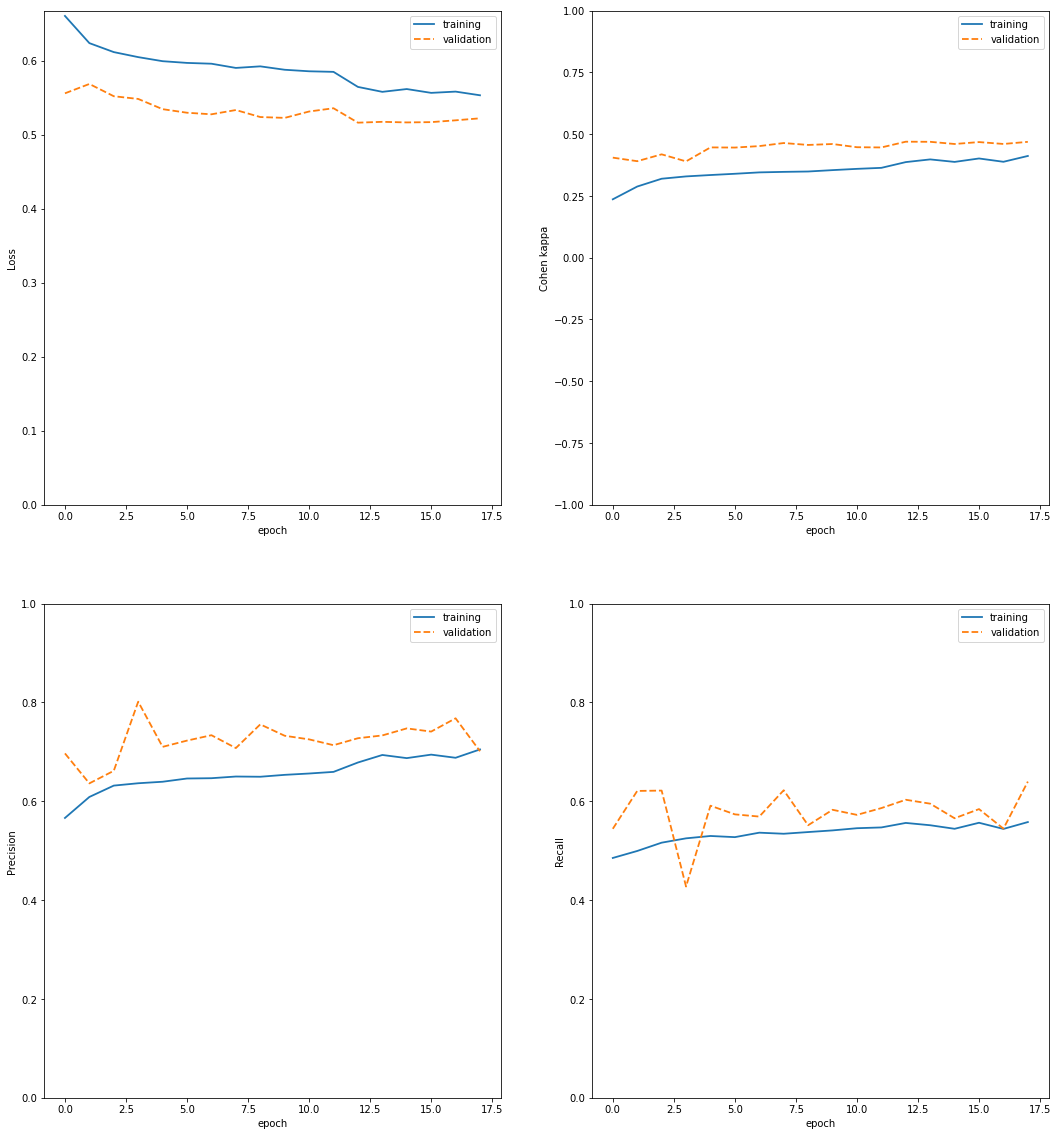

In [16]:
plot_metrics(history)

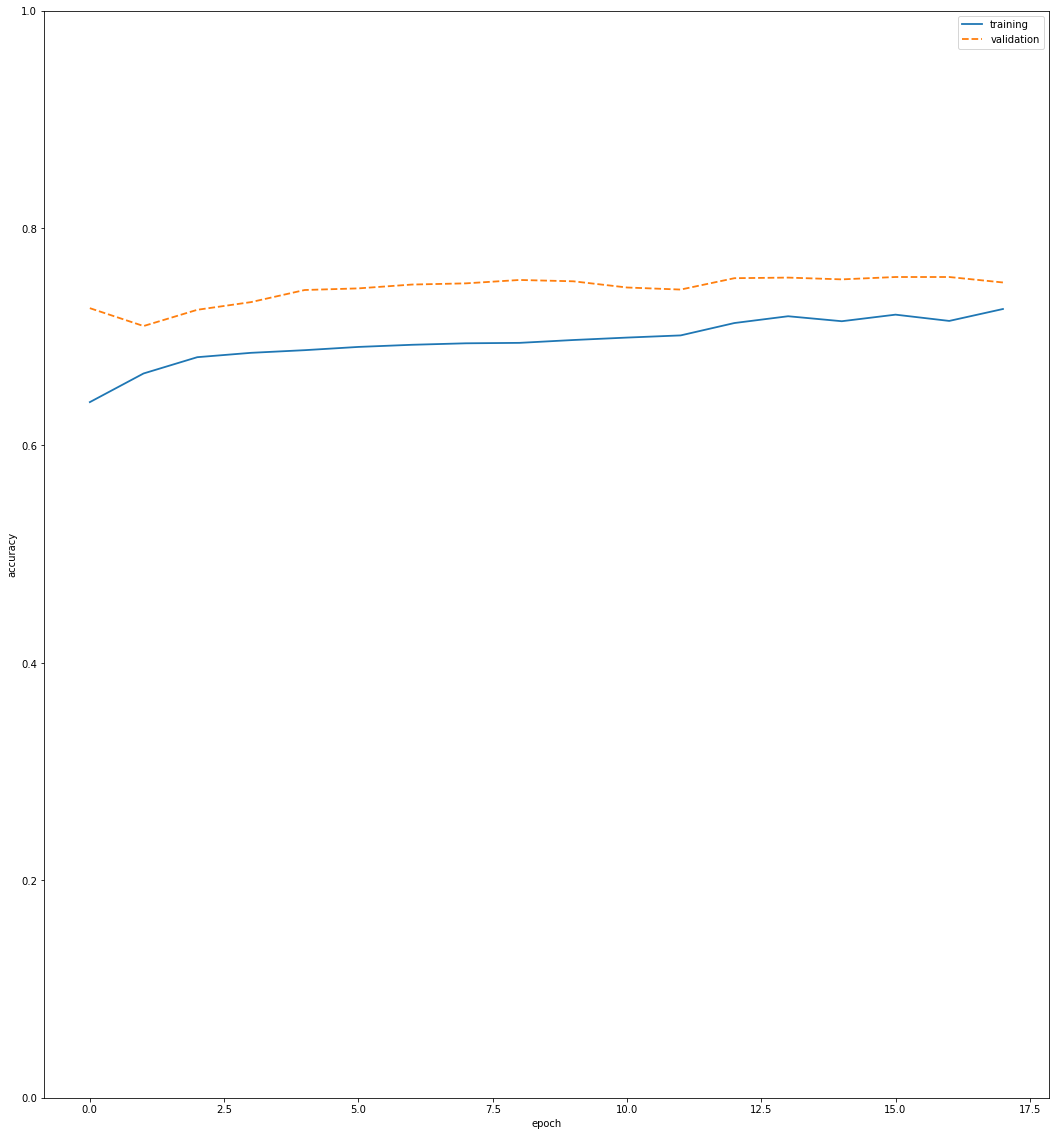

In [17]:
plot_accuracy(history)

In [18]:
## Finetuning
trained_model = tf.keras.models.load_model(
    model_path,
    custom_objects={'F1Score': F1Score}
)

In [19]:
def unfreeze_model(model):
    for layer in model.layers[:]:
        if not isinstance(layer, tf.keras.layers.BatchNormalization):
            layer.trainable = True
    model.compile(
        optimizer = tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9),
        loss=tf.keras.losses.BinaryCrossentropy(),
        metrics=METRICS
    )

In [20]:
reduce_lr_on_plateau = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_cohen_kappa",
    verbose=1,
    patience=4,
    mode="max",
    factor=0.2,
    min_lr=1e-10,
)

base_model_name = 'efficientnetv2-b1'
finetune_path = f'models/without_clahe/{base_model_name}_modified_finetuned_v2.h5'

finetuning_checkpoint  = tf.keras.callbacks.ModelCheckpoint(
    filepath=finetune_path,
    monitor='val_cohen_kappa',
    mode='max',
    save_best_only = True,
)

finetuning = f'training_records/without_clahe/{base_model_name}_modified_finetuning_v2.csv'
fine_logs = tf.keras.callbacks.CSVLogger(filename=finetuning, separator=',')


In [21]:
unfreeze_model(trained_model)

In [22]:
print(np.sum([tf.keras.backend.count_params(w) for w in trained_model.trainable_weights]))
print(np.sum([tf.keras.backend.count_params(w) for w in trained_model.non_trainable_weights]))


7577973
143680


In [23]:
finetune_history = trained_model.fit(
    train_batches,
    epochs=25, 
    validation_data=valid_batches,
    callbacks=[early_stopping, reduce_lr_on_plateau, finetuning_checkpoint, fine_logs],
)

Epoch 1/25
3681/3681 [==============================] - 788s 210ms/step - loss: 0.5870 - binary_accuracy: 0.7102 - precision: 0.6776 - recall: 0.5396 - cohen_kappa: 0.3779 - f1_score: 0.6008 - val_loss: 0.5059 - val_binary_accuracy: 0.7632 - val_precision: 0.8556 - val_recall: 0.4825 - val_cohen_kappa: 0.4643 - val_f1_score: 0.6170 - lr: 0.0010
Epoch 2/25
3681/3681 [==============================] - 769s 209ms/step - loss: 0.5487 - binary_accuracy: 0.7363 - precision: 0.7195 - recall: 0.5752 - cohen_kappa: 0.4356 - f1_score: 0.6393 - val_loss: 0.4858 - val_binary_accuracy: 0.7779 - val_precision: 0.7346 - val_recall: 0.6859 - val_cohen_kappa: 0.5300 - val_f1_score: 0.7094 - lr: 0.0010
Epoch 3/25
3681/3681 [==============================] - 769s 209ms/step - loss: 0.5317 - binary_accuracy: 0.7465 - precision: 0.7311 - recall: 0.5948 - cohen_kappa: 0.4586 - f1_score: 0.6559 - val_loss: 0.4708 - val_binary_accuracy: 0.7870 - val_precision: 0.8385 - val_recall: 0.5711 - val_cohen_kappa: 0.

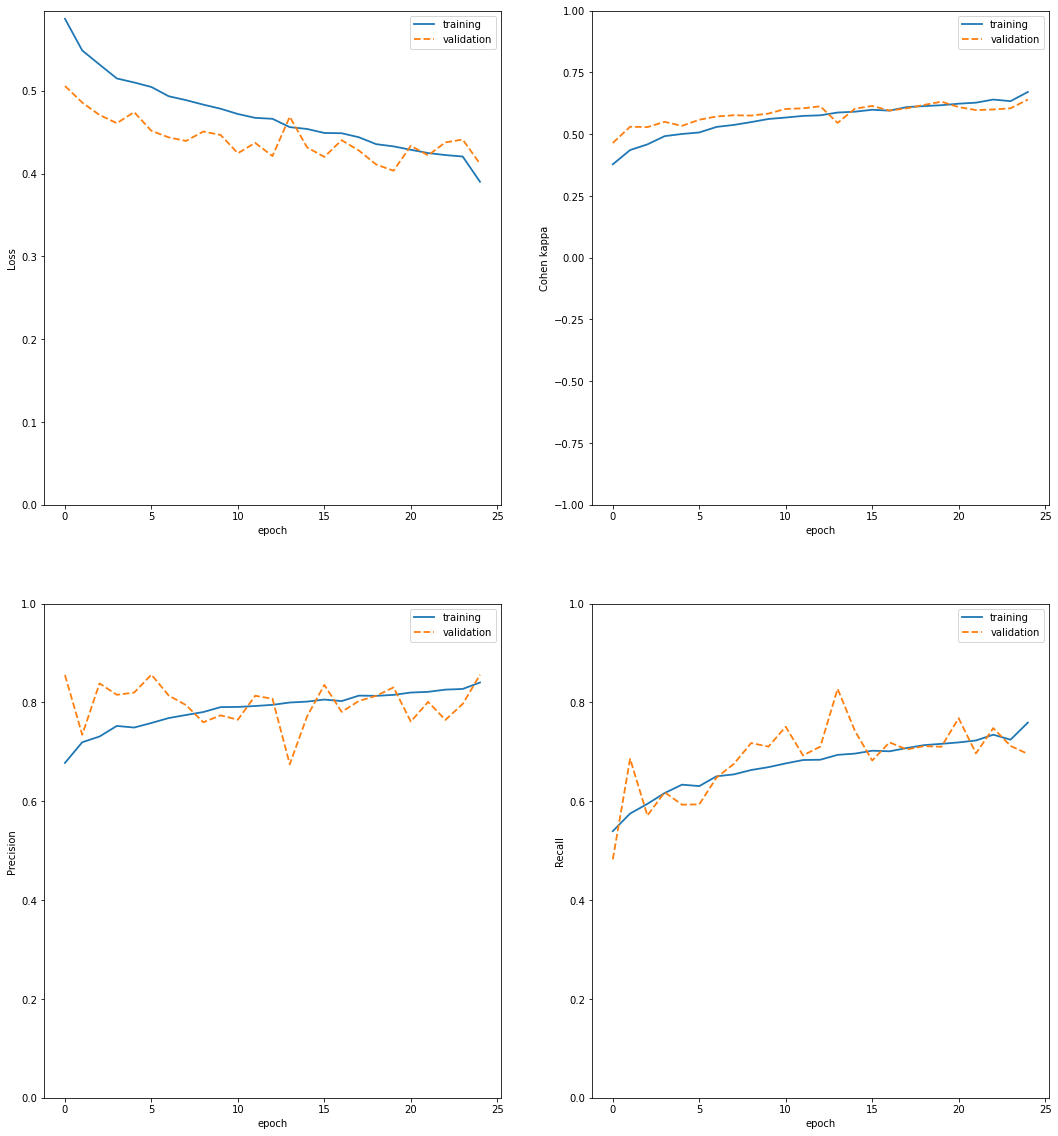

In [24]:
plot_metrics(finetune_history)


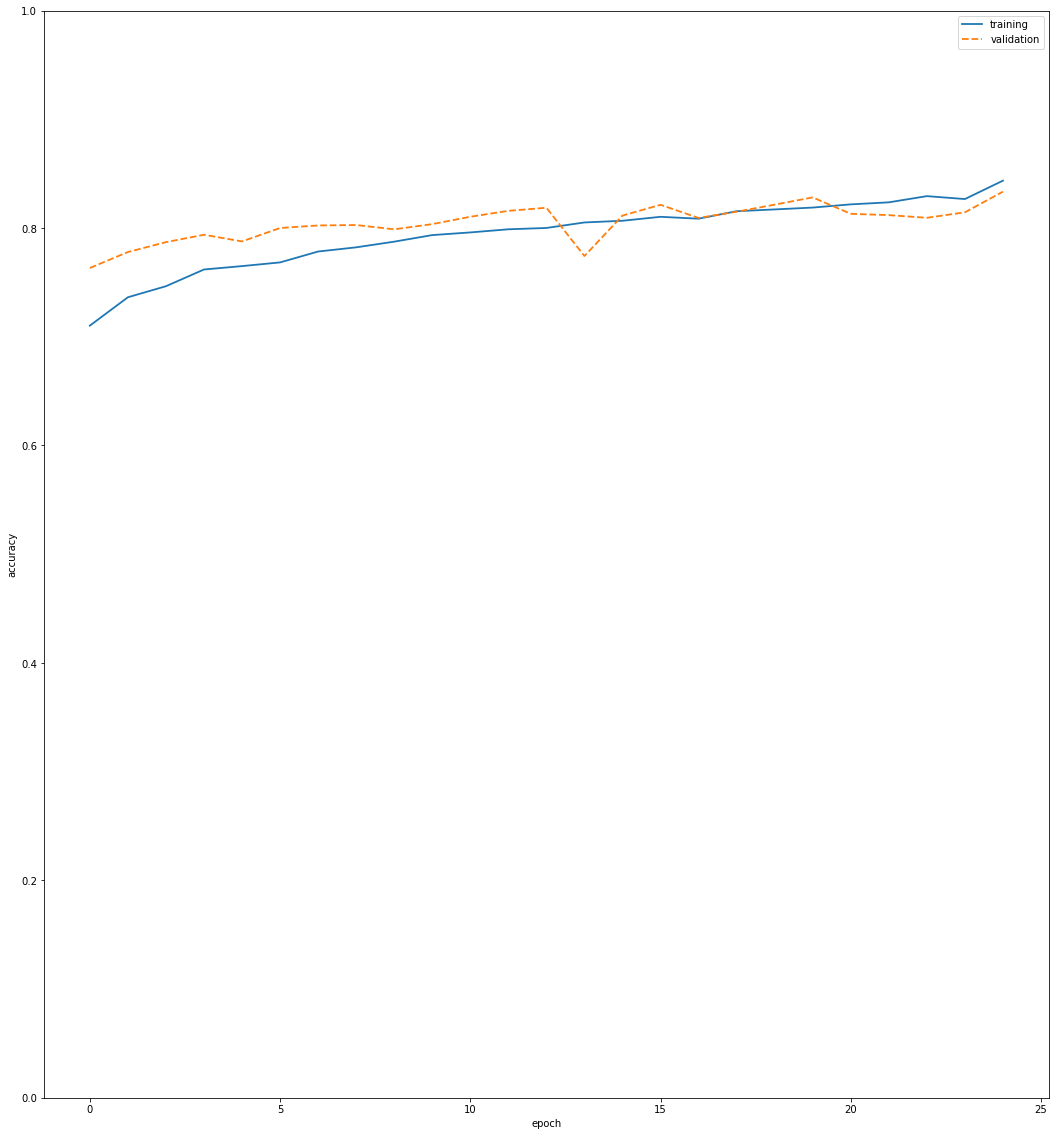

In [25]:
plot_accuracy(finetune_history)

In [26]:
# get the loss value & metrics values for the model in validation mode
evaluation_metrics = trained_model.evaluate(valid_batches, verbose=1)

921/921 [==============================] - 55s 59ms/step - loss: 0.4119 - binary_accuracy: 0.8335 - precision: 0.8559 - recall: 0.6959 - cohen_kappa: 0.6400 - f1_score: 0.7676


In [27]:
loss = evaluation_metrics.pop(0)

print(f"val loss    : {loss}")
for metric, score in zip(METRICS, evaluation_metrics):

    print(f"{metric.name + ' ' * (12 - len(metric.name))}: {score}")

val loss    : 0.41186055541038513
binary_accuracy: 0.8334691524505615
precision   : 0.8558748960494995
recall      : 0.6958763003349304
cohen_kappa : 0.6400012969970703
f1_score    : 0.7676270604133606


In [28]:
if os.path.isfile(finetune_path) is False:
    trained_model.save(finetune_path)